# Setup

In [1]:
# Modules
%matplotlib inline
# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sb
import colorcet as cc
# Numerics
import numpy as np                
import xarray as xr
import pandas as pd
# System
import sys 
import pathlib
import subprocess

In [2]:
run_download_script = False

## General plotting choices

In [3]:
# Graphical choices
wm2 = '(W/' + r'm$^2$'+ ')' # Watts per meter squared
figdir = pathlib.Path('..')
fig_width = 14.2/2.54 # AGU text width is 14.2 cm; here in in

# Figure details 
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams["legend.frameon"] = False


#
# Choose a categorical set of colors, assign colors for each meaning
#
cols = cc.glasbey_dark
col_lw = cols[0]
col_sw = cols[1]
#
# Colors for each model - I guess I want a vector in the same order as realizations? 
#
# Function that takes a list of model names and returns the colors 
#   Brittle: fixed color mapping, fixed model names
def lbl_cols(realizations):
    col_dict = {'ARTS-2-3':2,
                'GFDL-GRTCODE':3, 
                'GFDL-RFM-DISORT':4, 
                'HadGEM3-GC31-LL':5,
                'LBLRTM-12-8':6, 
                '4AOP-v1-5':12} # Colors 6 and 7 are quite similar
    return([cols[col_dict[r[:-6]]] for r in realizations])


def gcm_cols(realizations):
    col_dict = {'GFDL-AM4':8, 
                'HadGEM3-GC31-LL':5,
                'RTE-RRTMGP-181204':10,
                'MIROC6':9}

    return([cols[col_dict[r[:-6]]] for r in realizations])

#
# Forcing indexes
#
def is_forcingindex(index, realizations): 
    return(['-f{:01.0f}'.format(index) in r for r in realizations])
    
# Matplotlib takes a single marker, not a vector of them, doh
def forcing_marker(realization):
    marker_dict={"f1":"o", "f2":"s", "f3":"D"}
    return(marker_dict[realization[-2:]])

In [4]:
save_figs = True

# Sampling error (figure 1)

## Data ingest

In [5]:
errs_vs_N     = pd.read_csv('forcing-sampling-errors.txt', skiprows = 5, delimiter=r"\s+")
errs_rnd_vs_N = pd.read_csv('forcing-random-sampling-errors.txt', skiprows = 6, delimiter=r"\s+")
errs_100      = pd.read_csv('Forcing-and-Errors-100-cols.txt')

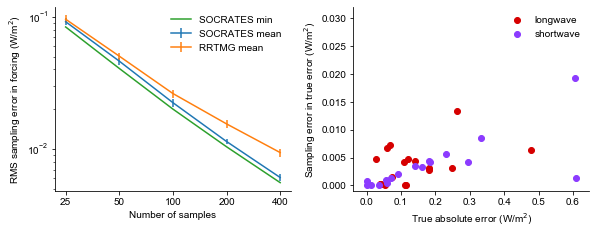

In [6]:
showRandomErrs = False
# Set default aspect ratio for two figures side-by-side
aspect_ratio =  .4
size_mult    = 1.5
mpl.rcParams["figure.figsize"] = [fig_width * size_mult, fig_width * aspect_ratio * size_mult]

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.errorbar(errs_vs_N['N'], errs_vs_N['Soc-mean'], errs_vs_N['Soc-stdv'], label = "SOCRATES mean")
ax1.errorbar(errs_vs_N['N'], errs_vs_N['R-mean'], errs_vs_N['R-stdv'], label="RRTMG mean")
ax1.loglog  (errs_vs_N['N'], errs_vs_N['Soc-min'], label="SOCRATES min")
ax1.set(xlabel="Number of samples", ylabel="RMS sampling error in forcing " + wm2)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='minor',      # both major and minor ticks are affected
    bottom=False) # labels along the bottom edge are off
if showRandomErrs:
    ax1.loglog  (errs_rnd_vs_N['N'], errs_rnd_vs_N['Soc-mean'])
    ax1.loglog  (errs_rnd_vs_N['N'], errs_rnd_vs_N['R-mean'])

ax1.set_xticks(errs_vs_N['N'])
ax1.set_xticklabels(errs_vs_N['N'])
ax1.legend()

ax2.scatter(np.abs(errs_100['Etrue-LW']), np.abs(errs_100['Esamp-LW']), label="longwave",  c = col_lw)
ax2.scatter(np.abs(errs_100['Etrue-SW']), np.abs(errs_100['Esamp-SW']), label="shortwave", c = col_sw)
ax2.set_ylim(bottom=-.001)
ax2.set(xlabel="True absolute error " + wm2, 
        ylabel="Sampling error in true error "+ wm2)
ax2.legend()
sb.despine()
fig.tight_layout()
if save_figs: fig.savefig(figdir.joinpath("Sampling-Errors.pdf"), dpi=600, transparent=True)


# Line-by-line and GCM results 

## Data ingest

In [7]:
if run_download_script: subprocess.run([sys.executable, "compute-lbl-gcm-global-mean-forcing.py"])
lw = xr.open_dataset("lw-lbl-models.nc")
sw = xr.open_dataset("sw-lbl-models.nc")
temp = xr.open_dataset("gcm-models.nc")
# GFDL, RRMTPG, and HadGEM have updated spectroscopy
gcm_subset = [r for r in temp.realization.values if "GFDL" in r or "RRTMGP" in r or "HadGEM" in r]
gcm = temp.sel(realization=gcm_subset)

toa = lw.isel(expt=0).plev.argmin().values
sfc = lw.isel(expt=0).plev.argmax().values

# Some of the RFMIP experiements include changed temperatures, 
#   sometimes with associated changes in water vapor
# We'll focus on changes to gas concentrations only 
expt_labels = lw.expt.values
isForcing = [f for f in expt_labels if ("+4K" not in f and "all" not in f)]
# We'll report 3 groups for forcings: 
#   scenarios (PI, future, LGM; 3 values)
#   PI forcing (total and by constituent; 6 values)
#   and idealized CO2 forcing (4 values)
piForcing  = [f for f in expt_labels if ("PI"  in f and "all" not in f)]
co2Forcing = sorted([f for f in expt_labels if "xCO2" in f])
scenarios  = ["PD", "future", "LGM"]

# Example results: forcing at present-day (Figure 2) 

In [8]:
def plot_forcing(ax, fluxes, expt="PD", forcing = True, band=None, ylab_format_string="{:.3f}"): 
    toa = fluxes.isel(expt=0).plev.argmin().values
    sfc = fluxes.isel(expt=0).plev.argmax().values
    if band is None: band = "l" if "rld" in fluxes else "s"
    q = "f" if forcing else "r"
    net_forcing  = fluxes[q + band + "n"].sel(expt=expt)
    abs_forcing  = fluxes[q + band + "a"].sel(expt=expt)
    realizations = fluxes.realization
    #
    # Plotting choices
    #
    inc = .0375 # Worth trying... 
    n   = realizations.size
    deltaX = np.ma.masked_array(np.linspace(-inc*n, inc*n, num=n))
    
    for f in [1,2,3]: # f is forcing index
        # TOA, surface, net absorption 
        mask = is_forcingindex(f, realizations.values)
        all_lbl_cols = lbl_cols(realizations.values)
        these_cols = [all_lbl_cols[i] for i in range(len(mask)) if mask[i]]
        ax.scatter(0 + deltaX[mask], 
                    net_forcing.sel(level=toa, realization=mask), 
                    c=these_cols,
                    marker=forcing_marker('-f{:01.0f}'.format(f)))
        ax.scatter(1 + deltaX[mask], 
                    net_forcing.sel(level=sfc, realization=mask), 
                    c=these_cols,
                    marker=forcing_marker('-f{:01.0f}'.format(f)))
        ax.scatter(2 + deltaX[mask], 
                    abs_forcing.sel(           realization=mask), 
                    c=these_cols,
                    marker=forcing_marker('-f{:01.0f}'.format(f)))

    sb.despine(bottom=True)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(["TOA", "Sfc", "Absorption"])
    y_vals = [net_forcing.sel(level=toa).mean().values, 
              net_forcing.sel(level=sfc).mean().values, 
              abs_forcing.mean().values]
    ax.set_yticks(y_vals)
    ax.set_yticklabels([ylab_format_string.format(x) for x in y_vals])
    if forcing: 
        ax.set(ylabel = "Forcing " + wm2)
    else:
        ax.set(ylabel = "Flux " + wm2)

def make_legend(fig, realizations, x_left = 1.5, y_top = .1, cols = lbl_cols):
    #
    # Generalize this - we're writing colored text at a set of x,y postions 
    # 
    names = np.unique([r[:-6] for r in realizations.values])
    # Because it's last in the dictionary and everyone else is alphabetical
    if("4AOP-v1-5" in names): names = np.roll(names,-1)
    bottom, top = fig.get_ylim()
    y_size = top - bottom
    left, right = fig.get_xlim()
    ys = top - y_top - np.arange(len(names)) * y_size/22.5
    for i in range(len(names)):
        fig.text(x_left, ys[i], names[i], color=cols([names[i] + "-p1-f1"])[0])

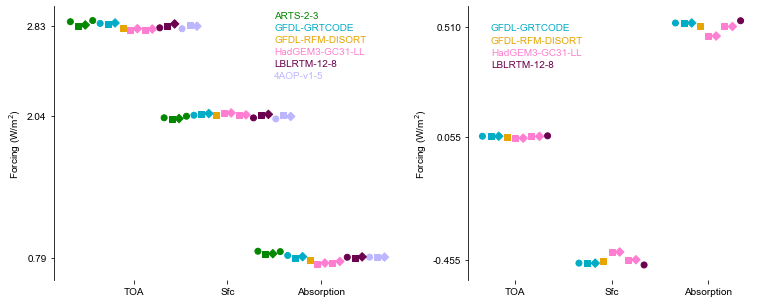

In [9]:
# Set default aspect ratio for two figures side-by-side
aspect_ratio =  .4
size_mult    = 2.25
mpl.rcParams["figure.figsize"] = [fig_width * size_mult, fig_width * aspect_ratio * size_mult]
#https://matplotlib.org/3.1.0/tutorials/intermediate/gridspec.html
width_ratios = [1.1, .9]
fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw = {'width_ratios':width_ratios})
plot_forcing(ax1, lw, ylab_format_string="{:.2f}")
make_legend(ax1, lw.realization)
plot_forcing(ax2, sw)
make_legend(ax2, sw.realization, x_left = -0.25)
if save_figs: fig.savefig(figdir.joinpath('Reference-forcing-present-day.pdf'), dpi=600, transparent=True, bbox_inches='tight')

### Agreement among models across experiements - forcing... 

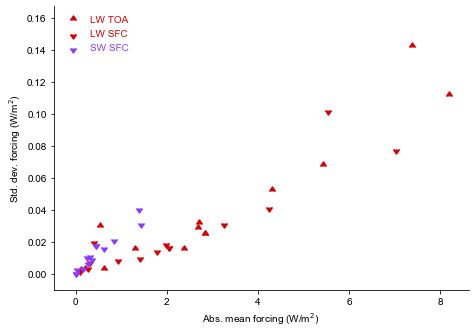

In [10]:
# Set default aspect ratio for two figures side-by-side
aspect_ratio = 4.8/6.8
size_mult    = 1.2
mpl.rcParams["figure.figsize"] = [fig_width * size_mult, fig_width * aspect_ratio * size_mult]
fig, ax = plt.subplots()


ax.scatter(xr.ufuncs.fabs(lw.fln.sel(level=toa, expt=isForcing).mean(dim="realization")), 
                          lw.fln.sel(level=toa, expt=isForcing).std (dim="realization"), 
                          label="LW TOA", c=col_lw, marker=10)
ax.scatter(xr.ufuncs.fabs(lw.fln.sel(level=sfc, expt=isForcing).mean(dim="realization")), 
                          lw.fln.sel(level=sfc, expt=isForcing).std (dim="realization"), 
                          label = "LW SFC", c=col_lw, marker=11)
ax.scatter(xr.ufuncs.fabs(sw.fsn.sel(level=sfc, expt=isForcing).mean(dim="realization")), 
                           sw.fsn.sel(level=sfc, expt=isForcing).std (dim="realization"), 
                           label = "SW SFC", c=col_sw, marker=11)
ax.set(xlabel="Abs. mean forcing " + wm2, 
       ylabel="Std. dev. forcing " + wm2)
l = ax.legend()
for i in l.get_texts()[:2]: 
    plt.setp(i, color=col_lw)
plt.setp(l.get_texts()[2], color=col_sw)
sb.despine()
plt.tight_layout()
if save_figs: fig.savefig(figdir.joinpath('Forcing-Mean-and-StdDev.pdf'), dpi=600, transparent=True, bbox_inches='tight')

### ... and fluxes

In [11]:
xr.concat([lw.rln.sel(expt="PI", level=toa).std (dim="realization"),
           lw.rln.sel(expt="PI", level=sfc).std (dim="realization"),
           sw.rsn.sel(expt="PI", level=sfc).std (dim="realization")], 
           dim = ["LW TOA", "LW SFC", "SW TOA"]).to_dataframe() #.to_latex(float_format="{:1.3f}".format, buf="pd-flux-stddev.tex")

,expt,rln
concat_dim,,
LW TOA,PI,0.577901
LW SFC,PI,0.459689
SW TOA,PI,0.691989


# LBL agreement vs GCM error

In [12]:
# https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib
def abline(ax, slope, intercept):
    """Plot a line from slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--')   


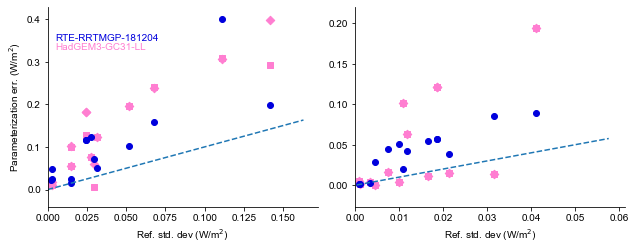

In [13]:
# Set default aspect ratio for two figures side-by-side
aspect_ratio = .4
size_mult    = 1.6
mpl.rcParams["figure.figsize"] = [fig_width * size_mult, fig_width * aspect_ratio * size_mult]
fig, (ax1, ax2) = plt.subplots(1, 2)


# Plot the errors for each GCM parameterization 
# 
# I bet there's a better way to do this - right now it's a loop over realizations so we can plot values by experiement
#    against values by experiment and by model
#
for m in gcm.realization.values: 
    ax1.scatter(lw.fln.sel(expt=isForcing).isel(level=toa).std(axis=0),
                xr.ufuncs.fabs((gcm.sel(realization=m, expt=isForcing) - lw.sel(realization="LBLRTM-12-8-p1-f1", expt=isForcing)).fln).isel(level=toa).values, 
                label=m[:-6], c=gcm_cols([m]), marker=forcing_marker(m))

#
# Adapted from make_legend above 
#
gcm_names = np.unique([r[:-6] for r in gcm.realization.values])
bottom, top = ax1.get_ylim()
y_size = top - bottom
left, right = ax1.get_xlim()
ys = top -.1 + np.arange(len(gcm_names)) * y_size/22.5
for i in range(len(gcm_names)):
    ax1.text(.005, ys[i], gcm_names[i], color=gcm_cols([gcm_names[i] + "-p1-f1"])[0])

abline(ax1, 1, 0)
ax1.set_xlim(left=0)
sb.despine()
ax1.set(xlabel = "Ref. std. dev " + wm2, 
        ylabel = "Parameterization err. " + wm2)

# Shortwave 
for m in gcm.realization.values: 
    ax2.scatter(sw.fsn.sel(expt=isForcing).isel(level=sfc).std(axis=0),
                xr.ufuncs.fabs((gcm.sel(realization=m,expt=isForcing) - sw.sel(realization="LBLRTM-12-8-p1-f1",expt=isForcing)).fsn).isel(level=sfc).values, 
                label=m[:-6], c=gcm_cols([m]), marker=forcing_marker(m))
abline(ax2, 1, 0)
ax2.set_xlim(left=0)
sb.despine()
ax2.set(xlabel = "Ref. std. dev " + wm2)

plt.tight_layout()
if save_figs: fig.savefig(figdir.joinpath('LBL-and-GCM-error.pdf'), dpi=600, transparent=True)

# Table of forcings

In [14]:
meanForcing = xr.Dataset({'LW TOA':lw.fln.isel(level=toa).mean(axis=0), 
                          'LW SFC':lw.fln.isel(level=sfc).mean(axis=0),
                          'SW TOA':sw.fsn.isel(level=toa).mean(axis=0), 
                          'SW SFC':sw.fsn.isel(level=sfc).mean(axis=0)}, 
                        coords=lw.coords, attrs=lw.attrs)
meanForcing = meanForcing.drop("realization")

In [15]:
meanForcing.sel(expt=piForcing ).to_dataframe().to_latex(float_format="{:1.3f}".format, buf="pi-forcing.tex")
meanForcing.sel(expt=co2Forcing).to_dataframe().to_latex(float_format="{:1.3f}".format, buf="co2-forcing.tex")
meanForcing.sel(expt=scenarios ).to_dataframe().to_latex(float_format="{:1.3f}".format, buf="scenarios.tex")

# Fluxes under fixed dynamical heating

In [16]:
#
# For looking at these fluxes we'll need to be able to average globally
#
profiles = "http://aims3.llnl.gov/thredds/dodsC/user_pub_work/input4MIPs/CMIP6/RFMIP/" + \
           "UColorado/UColorado-RFMIP-1-2/atmos/fx/multiple/none/v20190401/multiple_input4MIPs_radiation_RFMIP_UColorado-RFMIP-1-2_none.nc"
inputs = xr.open_dataset(profiles)
profile_weights = inputs.profile_weight/inputs.profile_weight.sum('site')
inputs.close()

In [17]:
# Copied from the ingest script (compute-lbl-gcm-global-mean-forcing.py)
#   Which maybe I could just import
#
def compute_forcing(da, band_label):
    '''
    Compute forcing - up, down, net, absorption
    Forcing calculated as
     -(X-PD) for experiments with "PI" in the title,
       X-PD for +4K experiments,
       X-PI_CO2 for the CO2 experiments
       X-PI for all other experiments
    Parameters:
        da (xarray Dataset): variables rxd, rxu, rxn, and rxa for up, down, net, and column absorption where x is band_label
        band_label (char): 'l' for longwave, 's' for shortwave
    '''
    piExpts   = [f for f in expt_labels if "PI"  in f]
    tempExpts = [f for f in expt_labels if "+4K" in f]
    co2Expts  = [f for f in expt_labels if "xCO2" in f]
    for v in ["u", "d", "n", "a"]:
        fVar = "f"+band_label+v
        rVar = "r"+band_label+v
        da[fVar] = da[rVar] - da[rVar].sel(expt="PI")
        da[fVar].load()
        da[fVar].loc[dict(expt=piExpts)  ] = -(da[rVar].loc[dict(expt=piExpts)  ] - da[rVar].sel(expt="PD"))
        da[fVar].loc[dict(expt=co2Expts) ] =   da[rVar].loc[dict(expt=co2Expts) ] - da[rVar].sel(expt="PI CO2")
        da[fVar].loc[dict(expt=tempExpts)] =   da[rVar].loc[dict(expt=tempExpts)] - da[rVar].sel(expt="PD")
    return(da)


In [18]:
#
# GFDL's file containing fluxes and temperature profiles after 1 and 120 iterations of FDH
#
fdh_file = 'Stratospheric-adjustment/rfmip-irf-fdh-temperature-profiles.nc'
fdh = xr.open_dataset(fdh_file)
fdh = fdh.assign_coords(expt=expt_labels).drop(["profile_weight", "plev", "tlay", "tlev"])

# The FDH calculations are run at lower spectral resolution so the present-day fluxes are biased
#    Remove these fluxes, leaving only the magnitude of the adjustment    
fdh = (fdh.isel(flux_description=1) - fdh.isel(flux_description=0))
# Net flux, absorption
for b in ['s', 'l']: 
    fdh["r"+b+"n"] = fdh["r"+b+"d"] - fdh["r"+b+"u"]
    fdh["r"+b+"a"] = fdh["r"+b+"n"].sel(level=toa) - fdh["r"+b+"n"].sel(level=sfc)
#    
# This compute forcing from FDH-adjusted fluxes, so the baseline for most forcing calculations also includes FDH
#
fdh = compute_forcing(fdh, "l")
fdh = compute_forcing(fdh, "s")
#
# Global mean adjustment
#
adj_fluxes = (fdh*profile_weights).sum(dim='site')

#
# Global-mean IRF from the same model for comparison 
#
grt_fluxes = lw.sel(realization="GFDL-GRTCODE-p1-f1")
for v in [vv for vv in sw.variables if "fs" in vv or "rs" in vv]:  
    grt_fluxes[v] = sw.sel(realization="GFDL-GRTCODE-p1-f1")[v]


## Relationship between forcing and stratospheric adjustment assuming fixed dynamical heating  

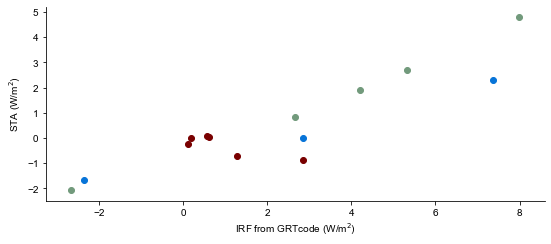

In [19]:
plt.scatter(grt_fluxes.sel(expt=piForcing ).isel(level=toa).fln, 
            adj_fluxes.sel(expt=piForcing ).isel(level=toa).rln, c=cols[15])
plt.scatter(grt_fluxes.sel(expt=scenarios ).isel(level=toa).fln, 
            adj_fluxes.sel(expt=scenarios ).isel(level=toa).rln, c=cols[16])
plt.scatter(grt_fluxes.sel(expt=co2Forcing).isel(level=toa).fln, 
            adj_fluxes.sel(expt=co2Forcing).isel(level=toa).rln, c=cols[17])

plt.xlabel("IRF from GRTcode (W/m$^2$)")
plt.ylabel("STA (W/m$^2$)")
sb.despine()
if save_figs: plt.savefig(figdir.joinpath('All-STAs.pdf'), dpi=600, transparent=True)

### Table: Ratio of adjustment to LW forcing at PD

In [20]:
(adj_fluxes/grt_fluxes).fln.isel(level=[toa,sfc]).sel( expt=piForcing).to_dataframe().to_latex(float_format="{:1.2f}".format, buf="pd-strat-adj.tex")

### Non-linear CO2 adjustment

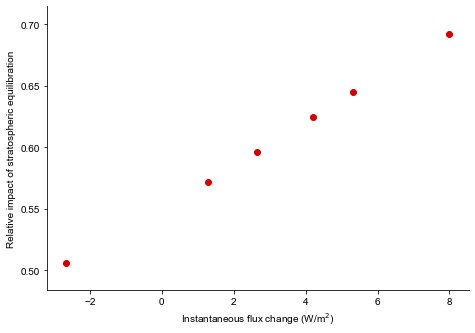

In [21]:
#
# Include PI CO2 experiment 
#
allCO2Forcing = co2Forcing
allCO2Forcing.extend(["PI CO2"])

aspect_ratio = 4.8/6.8
size_mult    = 1.2
mpl.rcParams["figure.figsize"] = [fig_width * size_mult, fig_width * aspect_ratio * size_mult]
fig, ax = plt.subplots()
ax.scatter(            grt_fluxes.fln.isel(level=toa).sel(expt=allCO2Forcing), 
            (adj_fluxes/grt_fluxes).fln.isel(level=toa).sel(expt=allCO2Forcing), 
            color = col_lw)
sb.despine()
ax.set(xlabel = "Instantaneous flux change (W/m$^2$)",
       ylabel = "Relative impact of stratospheric equilibration")
fig.tight_layout()
if save_figs: fig.savefig(figdir.joinpath('CO2-adjustment-ratio.pdf'), dpi=600, transparent=True)

In [22]:
#
# File provided by GFDL includes fluxes, temperature profiles 
#   But temperature in the first index has already been adjusted once, so we have to get the 
#   unpertubed profiles from from the RFMIP file 
#
inputs = xr.open_dataset(profiles).assign_coords(expt=expt_labels)
inputs = (inputs * profile_weights).sum(dim='site').swap_dims({"layer":"pres_layer", "level":"pres_level"})
t_unp = inputs.temp_level.sel(expt="PD")
o3_change = (inputs.sel(expt="PD") - inputs.sel(expt="PI O3")).ozone
pres_layer = inputs.pres_layer
inputs.close()

inputs = xr.open_dataset(fdh_file).isel(flux_description=1).assign_coords(expt=expt_labels)
t_sta = (inputs.tlev*inputs.profile_weight/inputs.profile_weight.sum('site')).sum(dim='site')
p_lev = lw.plev.sel(realization="GFDL-GRTCODE-p1-f1")
inputs.close()

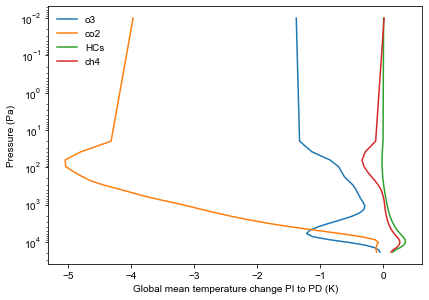

In [23]:
plt.plot((t_sta.sel(expt="PD") - t_sta.sel(expt="PI O3") ).where(p_lev <= 20000, drop=True), 
         p_lev.where(p_lev <= 20000, drop=True), label="o3")
plt.plot((t_sta.sel(expt="PD") - t_sta.sel(expt="PI CO2")).where(p_lev <= 20000, drop=True), 
         p_lev.where(p_lev <= 20000, drop=True), label="co2")
plt.plot((t_sta.sel(expt="PD") - t_sta.sel(expt="PI HCs")).where(p_lev <= 20000, drop=True), 
         p_lev.where(p_lev <= 20000, drop=True), label="HCs")
plt.plot((t_sta.sel(expt="PD") - t_sta.sel(expt="PI CH4") ).where(p_lev <= 20000, drop=True), 
         p_lev.where(p_lev <= 20000, drop=True), label="ch4")
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Global mean temperature change PI to PD (K)")
plt.ylabel("Pressure (Pa)")
plt.yscale("log")
plt.savefig(figdir.joinpath('Temp-profile-changes.pdf'), dpi=600, transparent=True)

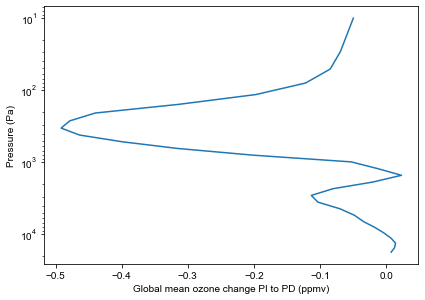

In [24]:
#
# What's the global-mean change in the stratospheric ozone profile? (not in the paper)
#
plt.plot(1.e6 * o3_change.where(pres_layer <= 20000, drop=True), 
         pres_layer.where(pres_layer <= 20000, drop=True))
plt.gca().invert_yaxis()
plt.xlabel("Global mean ozone change PI to PD (ppmv)")
plt.ylabel("Pressure (Pa)")
plt.yscale("log")


plt.savefig(figdir.joinpath('Ozone-profile-changes.pdf'), dpi=600, transparent=True)
